In [1]:
import pandas as pd

# Load the data from the file into a DataFrame
file_path = 'data/20240102133855.txt'
df = pd.read_csv(file_path, sep='\t')  # Assuming the separator is a tab, as common in such data logs

In [2]:
df.head() 

,时间,设备名称,加速度X(g),加速度Y(g),加速度Z(g),角速度X(°/s),角速度Y(°/s),角速度Z(°/s),角度X(°),角度Y(°),...,磁场X(uT),磁场Y(uT),磁场Z(uT),四元数0(),四元数1(),四元数2(),四元数3(),温度(°C),版本号(),电量(%)
0,2024-1-2 13:38:55:991,WT901BLE67(D1376ACA69A3),-0.010,0.004,0.998,0.0,0.0,0.0,0.26,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.1,10080.1.7,100
1,2024-1-2 13:38:56:83,WT901BLE67(D1376ACA69A3),-0.011,0.005,0.998,0.0,0.0,0.0,0.26,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.1,10080.1.7,100
2,2024-1-2 13:38:56:201,WT901BLE67(D1376ACA69A3),-0.011,0.004,0.998,0.0,0.0,0.0,0.26,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.1,10080.1.7,100
3,2024-1-2 13:38:56:263,WT901BLE67(D1376ACA69A3),-0.010,0.003,0.998,0.0,0.0,0.0,0.26,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.1,10080.1.7,100
4,2024-1-2 13:38:56:385,WT901BLE67(D1376ACA69A3),-0.010,0.004,0.998,0.0,0.0,0.0,0.26,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.1,10080.1.7,100


/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from c

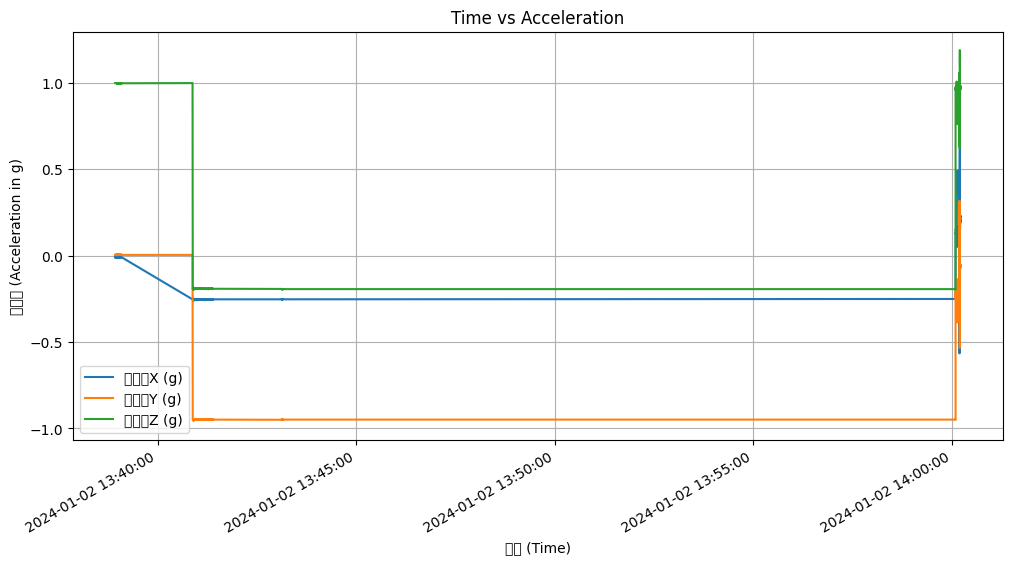

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Convert the '时间' column to datetime format for proper plotting
df['时间'] = pd.to_datetime(df['时间'])

# Plotting
plt.figure(figsize=(12, 6))

# Plotting each acceleration component
plt.plot(df['时间'], df['加速度X(g)'], label='加速度X (g)')
plt.plot(df['时间'], df['加速度Y(g)'], label='加速度Y (g)')
plt.plot(df['时间'], df['加速度Z(g)'], label='加速度Z (g)')

# Formatting the plot
plt.xlabel('时间 (Time)')
plt.ylabel('加速度 (Acceleration in g)')
plt.title('Time vs Acceleration')
plt.legend()
plt.grid(True)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate() # Auto format for better date representation
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Show the plot
plt.show()
